# Make $A_s$ maps

In [1]:
#set up values and functions
#------packages-------------------
%pylab inline

import healpy as hp

#-------constants------------------
TCMB = 2.7255  # Kelvin
hplanck = 6.626070150e-34  # MKS
kboltz = 1.380649e-23  # MKS


#-------functions------------------
#defines the ell power law that we will use for the A_s spectrum
def powerlaw(ell, alpha):
    return (ell/ 80.)**alpha

#defines a normal planck distribution 
def normed_cmb_thermo_units(nu):
    X = hplanck * nu / (kboltz * TCMB)
    eX = np.exp(X)
    return eX * X**4 / (eX - 1.)**2

#define the synchrotron SED.
#define what frequency map we want to look at. Start with 2.3 GHz
nu0 = 2.3e9 

def normed_synch(nu, beta):
    if beta is not np.array:
        beta = np.array(beta)
    return (nu/nu0)**(2.+beta[..., np.newaxis])

def scale_synch(nu, beta):
    unit = normed_synch(nu, beta) * normed_cmb_thermo_units(nu0) / normed_cmb_thermo_units(nu)
    return unit


#-------BB parameters (to start)--------
A_BB = 1.7e3
alpha_BB = -3.0
beta_BB = -3.2

#-------map paramters--------------------
nside = 128
Lmax = 384
ells = np.arange(1,Lmax+1)

Populating the interactive namespace from numpy and matplotlib


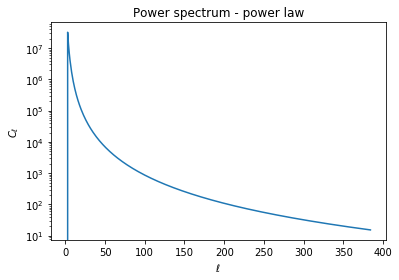

In [2]:
#define C_ell with a power law dependence on ell
pcls = A_BB * powerlaw(ells, alpha_BB)
pcls[0] = 0 
pcls[1] = 0

#input power spectrum
semilogy(ells,pcls)
xlabel("$\ell$")
ylabel("$C_\ell$")
title("Power spectrum - power law");

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


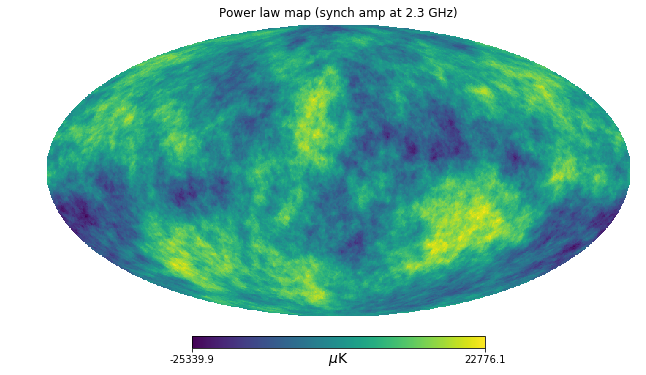

In [3]:
#produce power law map
sbb = hp.synfast(pcls, nside, new=True)
hp.mollview(sbb, unit=r'$\mu \rm K$', title='Power law map (synch amp at 2.3 GHz)')

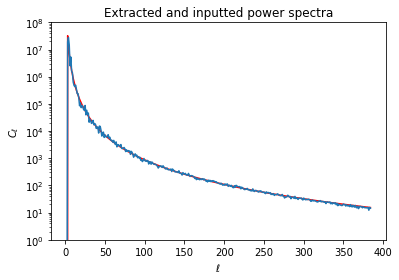

In [4]:
#now extract the power spectrum (the C_ells) from the map
check_cls = hp.anafast(sbb)

#compare the measured C_ell to the input C_ell curve

semilogy(ells, pcls, 'r')
semilogy(ells, check_cls)
xlabel("$\ell$")
ylabel("$C_\ell$")
title("Extracted and inputted power spectra")
ylim(1, 1e8);

# Produce maps including the SED

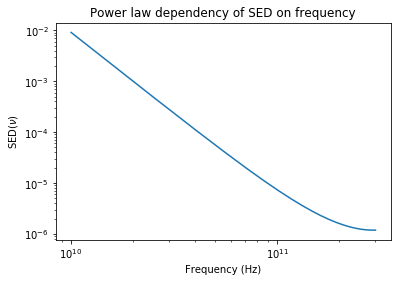

In [5]:
#define list of frequencies going from 10 to 300 GHz, sampling 20 points
freqs = np.linspace(10,300,20)*1.e9


#define the SED scaling
sed_scaling_const = scale_synch(freqs, beta_BB)


#plot the SED against frequency (on log log plot)
loglog(freqs, sed_scaling_const)
xlabel("Frequency (Hz)")
ylabel(r"$\mathrm{SED}(\nu)$") #the r is needed for the LaTeX
title("Power law dependency of SED on frequency");

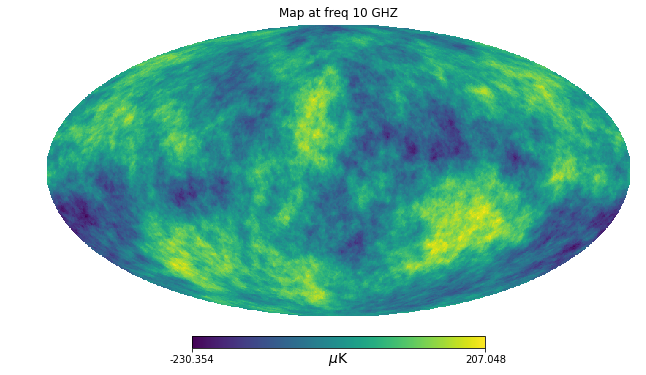

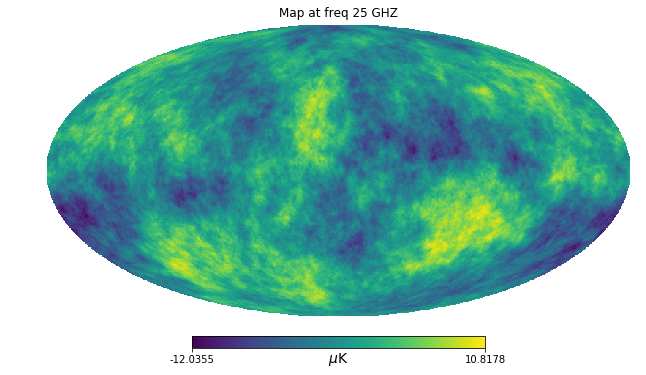

In [6]:
#the maps including SED at different frequencies
newmaps_const = sbb * sed_scaling_const[..., np.newaxis]

for k in range(2): #can extend this range up to 20 to get all the maps
    hp.mollview(newmaps_const[k], title = "Map at freq %d GHZ" %(1e-9*freqs[k]), unit = r"$\mu \rm K$")
    


# Allow $\beta$ to vary (uniform $C_\ell^\beta$).

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
mean of beta map = -3.2000000000000006
std of beta map = 0.13211695130646284


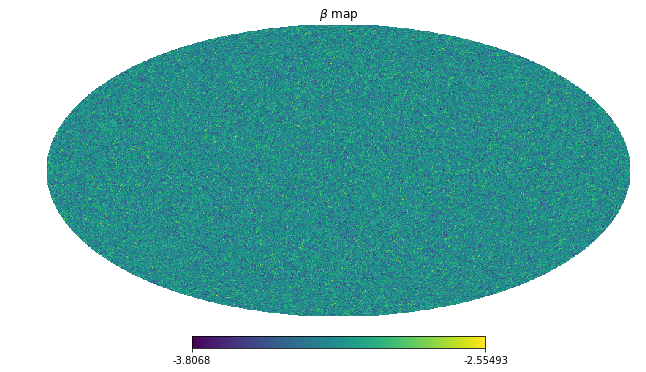

In [7]:
#define a standard deviation that gives rise to a map about the size
#expected

beta_sigma = 1.5e-6

#define a 'beta map' using uniform C_ell
beta_cls = beta_sigma * ones_like(ells)  #makes a vector [1.5e-6, ... , 1.5e-6] with the same shape as the ells
beta_map = hp.synfast(beta_cls, nside, new=True)

#update the map so that the mean is correct
beta_map -= (np.mean(beta_map) + 3.2)

#check map is as expected: mean ~3.2, std ~0.1
print("mean of beta map = " + str(np.mean(beta_map)))
print("std of beta map = " + str(np.std(beta_map)))

#view beta map
hp.mollview(beta_map, title=r"$\beta \ \rm map$")

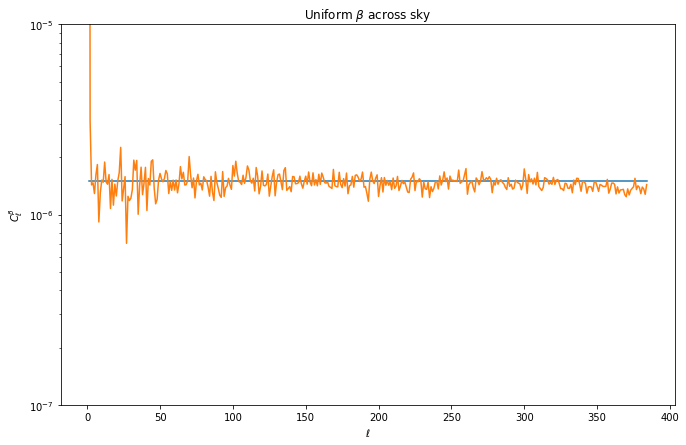

In [8]:
#check beta_cls from this map compared to input (uniform spectrum)
check_bcls = hp.anafast(beta_map)

figure(figsize=(11,7))
semilogy(ells, beta_cls)
semilogy(ells, check_bcls)
ylim(1e-7, 1e-5)
xlabel("$\ell$")
ylabel(r"$ C_\ell^{\beta}$") 
title(r"Uniform $\beta$ across sky");

In [9]:
beta_map.shape

(196608,)

# Use this $\beta$ to make a series of maps

(196608, 20)
(20,)
(20,)


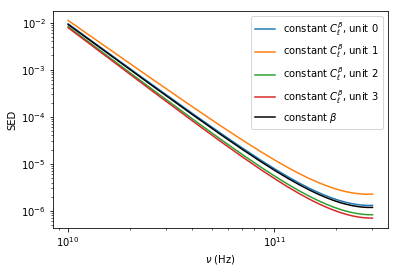

In [54]:
#we now want to take (nu/nu_0)^beta_map

#define the new, varying SED
sed_scaling_uniform = scale_synch(freqs, beta_map) 


print(sed_scaling_uniform.shape)
print(freqs.shape)
print(sed_scaling_const.shape)

for k in range(4):
    loglog(freqs, sed_scaling_uniform[k], label=r"constant $C_\ell^\beta$, unit %d" %k)
loglog(freqs, sed_scaling_const, 'k', label=r"constant $\beta$")
xlabel(r'$\nu$ (Hz)')
ylabel('SED')
legend();
#I have to pick out the right column so I'm not sure what I've done is right (I could have chosen [k] for any k)
#smaller than 196608-1

#now transpose the SED so that we can multiply it by our map
sed_scaling_uniform = sed_scaling_uniform.T

In [55]:
newmaps_uniform = beta_map * sed_scaling_uniform
newmaps_uniform.shape

(20, 196608)

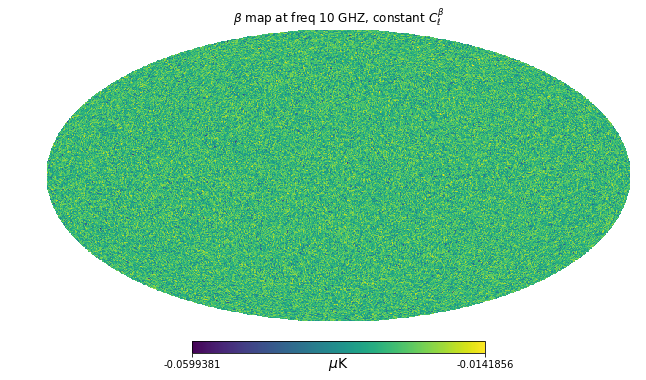

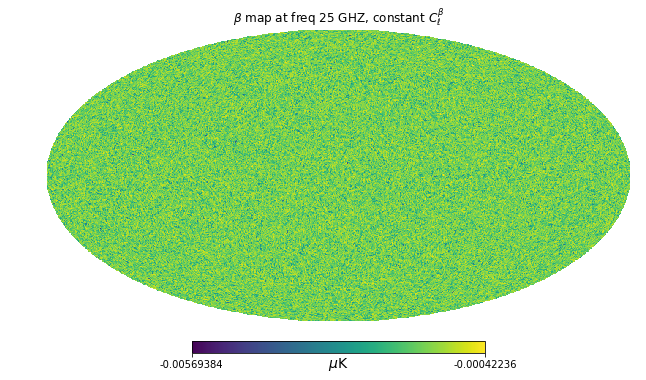

In [62]:
for k in range(2): #can extend this range up to 20 to get all the maps
    hp.mollview(newmaps_uniform[k], title = r"$\beta$ map at freq %d GHZ, constant $C_\ell^\beta$" %(1e-9*freqs[k]), unit = r"$\mu \rm K$")
    

# Create the "realistic maps" by multiplying the $\beta$ map and the $A_s$ map together

In [95]:
#----constant beta maps----
#the maps with constant beta are already realistic, so can just use
real_map_const = newmaps_const


#----uniform C_ell from beta
#the maps formed so far from the beta stuff do not include A_s, so must multiply by sbb
real_map_uniform = sbb * newmaps_uniform

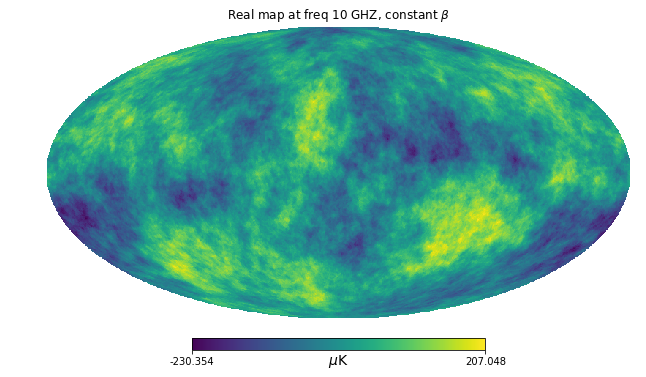

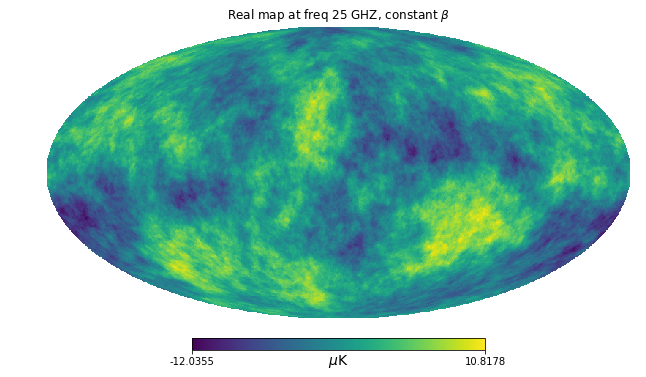

In [96]:
for k in range(2): #can extend this range up to 20 to get all the maps
    hp.mollview(real_map_const[k], title = r"Real map at freq %d GHZ, constant $\beta$" %(1e-9*freqs[k]), unit = r"$\mu \rm K$")

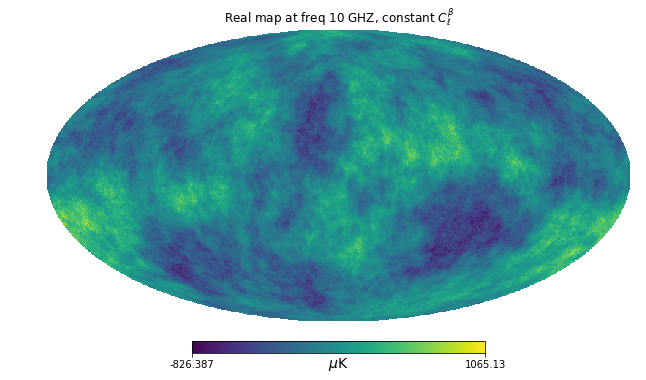

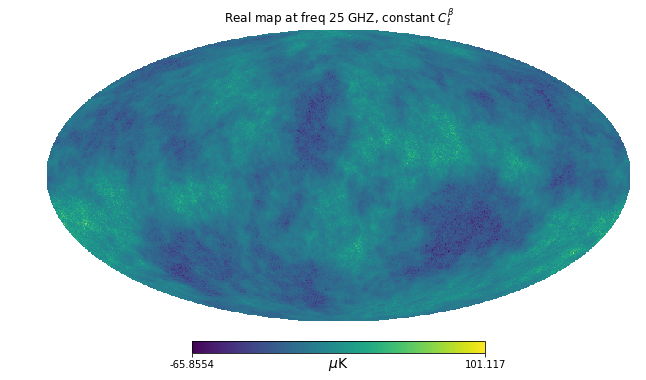

In [97]:
for k in range(2): #can extend this range up to 20 to get all the maps
    hp.mollview(real_map_uniform[k], title = r"Real map at freq %d GHZ, constant $C_\ell^\beta$" %(1e-9*freqs[k]), unit = r"$\mu \rm K$")

    

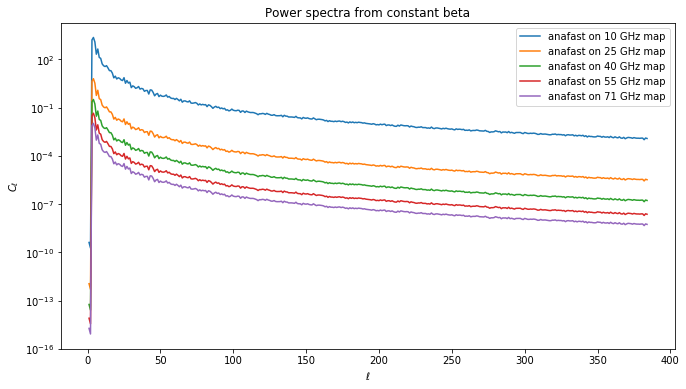

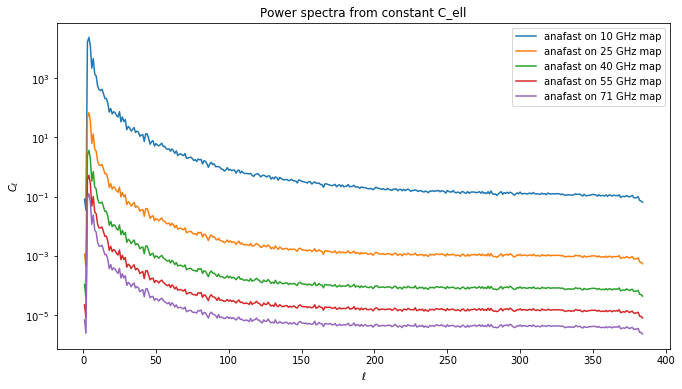

In [100]:
#extract power spectra

#-------constant beta------------------------
figure(figsize=(11,6))
for k in range(5): #could go up to 20
    semilogy(ells, hp.anafast(real_map_const[k]), label='anafast on %d GHz map' %(1e-9*freqs[k]))
    ylabel('$C_\ell$')
    xlabel('$\ell$')
    legend(loc=1)
    title("Power spectra from constant beta")
    
#------constant C_ell from the beta map------
figure(figsize=(11,6))
for k in range(5): #again, could go up to 20
    semilogy(ells, hp.anafast(real_map_uniform[k]), label='anafast on %d GHz map' %(1e-9*freqs[k]))
    ylabel('$C_\ell$')
    xlabel('$\ell$')
    legend()
    title("Power spectra from constant C_ell")

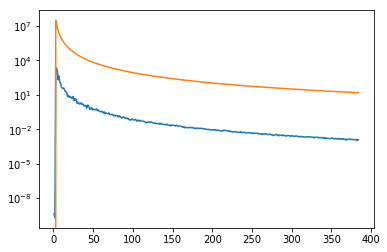

In [103]:
#need to compare this to the input spectra
real_check_cls_const_0 = hp.anafast(real_map_const[0])
semilogy(ells, real_check_cls_const_0)
semilogy(ells, pcls)



